<a href="https://www.kaggle.com/code/astrobutter/sydney-toll-roads?scriptVersionId=256077725" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Load standard data wrangling and system libraries
import numpy as np
import pandas as pd 
import os
import glob
import time
import sys

# For plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

In [2]:
# Load the data into a pandas dataframe

# Time how long this takes - start the timer
t1=time.time()

# Grab all the toll data files
all_files = sorted(glob.glob("/kaggle/input/nsw-toll-road-data/*.csv"))

# We will subset the data keeping only the columns we are interested in. This will save on memory.
COLS = ['Date','IntervalStart','TotalVolume','AssetID','GantryLocation','GantryGPSLatitude','GantryGPSLongitude']

# Force-hint the data types too for memory saving reasons
DTYPES = {
    'TotalVolume': 'uint32',
    'AssetID': 'category',
    'GantryLocation': 'category',
    'GantryGPSLatitude': 'float32',
    'GantryGPSLongitude': 'float32',
}
li = []

# Read data from multiple CSV files into a single pandas dataframe.
for filename in all_files:
    # print(filename)
    
    # Check if the file name contains "trips" and if there exists a 
    # corresponding file with "passages" in the same folder. If this is the 
    # case, skip the file and moves to the next one.
    #(we just want each "beep" by the toll, not the start and end destinations)
    fname = filename.split('_')
    if (fname[1]=='trips') and (fname[0]+'_passages_'+fname[2] in all_files):
        # print("Skipping", filename)
        pass
    # Skip the early m5 data.    
    elif fname[2] in ['adt.csv', 'awdt.csv', 'hourly.csv', 'monthly.csv']:
        pass
        
    else:
        try:
            df = pd.read_csv(filename, index_col=None, header=0, usecols=COLS, dtype=DTYPES, engine='pyarrow')
            df['Date_IntervalStart'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['IntervalStart'].astype(str))
            df = df.drop(columns=['Date','IntervalStart'])
            li.append(df)
        except:
            print("Failed", filename)
    
df = pd.concat(li, axis=0, ignore_index=True)

t2=time.time()
print(f"Time to Load: {t2-t1:,.1f}s")

Failed /kaggle/input/nsw-toll-road-data/M5_trips_adt.csv
Failed /kaggle/input/nsw-toll-road-data/M5_trips_awdt.csv
Failed /kaggle/input/nsw-toll-road-data/M5_trips_hourly.csv
Failed /kaggle/input/nsw-toll-road-data/M5_trips_monthly.csv
Time to Load: 277.4s


In [3]:
print(f"Size of df in memory:{sys.getsizeof(df)/1024**3:,.1f}GB, Rows:{df.shape[0]:,}, Columns:{df.shape[1]}")
print(f"That is {df['TotalVolume'].sum():,} total beeps on most of Sydney's Toll roads since 2009")
print(f"Let's plot all the {df.shape[0]:,} rows of data. Quite a few different ways to explore this....")

Size of df in memory:12.7GB, Rows:81,394,417, Columns:6
That is 5,092,966,483 total beeps on most of Sydney's Toll roads since 2009
Let's plot all the 81,394,417 rows of data. Quite a few different ways to explore this....


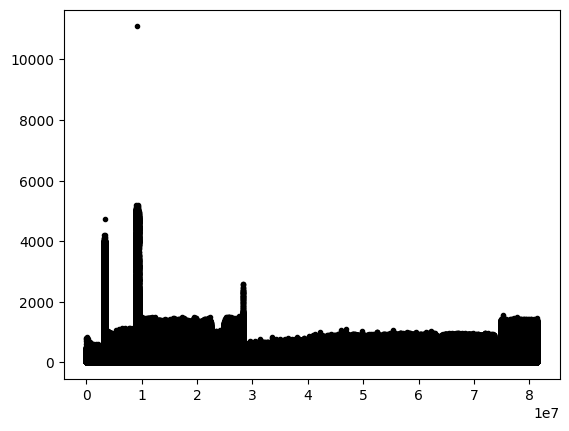

In [4]:
#Start with a simple time vs volume plot. 
plt.plot(df["TotalVolume"],'k.')

{'CCT': 833, 'ED': 4746, 'LCT': 1143, 'M2': 11094, 'M4': 1501, 'M5': 1536, 'M5E': 1071, 'M7': 2591, 'NCX': 561, 'WCX': 1555}
['M2', 'ED', 'M7', 'WCX', 'M5', 'M4', 'LCT', 'M5E', 'CCT', 'NCX']


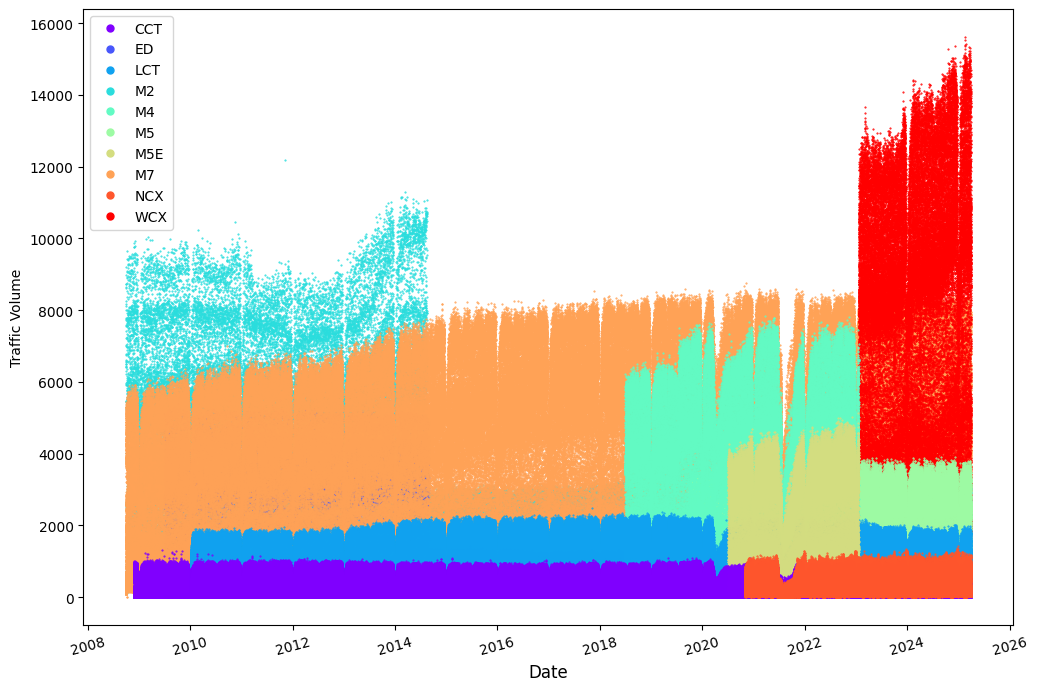

In [5]:
# Let's group by the different Toll roads.
# Then plot the volume.
# But make further groups of the "date" as there are many tolls on a single toll road.
# Use the sum method to combine those groups into a single value for each time and road.
tolls = df.groupby('AssetID')

fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)

# Find the road with the most Volume for a given day, so we can layer the plots nicely
maxlist={}
for name,group in tolls:
    maxlist[name]=group.groupby('Date_IntervalStart')["TotalVolume"].max().max()

print(maxlist)
maxlist=sorted(maxlist,key=maxlist.get,reverse=True)
print(maxlist)

# Get a new colour for each toll road
color = iter(cm.rainbow(np.linspace(0, 1, tolls.ngroups)))
for name,group in tolls:
    c = next(color)
    z=maxlist.index(name) #lower number in background
    ax.plot(group.groupby('Date_IntervalStart')["TotalVolume"].sum(),
         color=c, marker='.',markersize=1,linewidth=0.0,label=name,zorder=z)

plt.xlabel('Date',fontsize=12)
plt.ylabel('Traffic Volume')
plt.xticks(rotation=15)
plt.legend(loc='upper left',markerscale=10.)

plt.show()

What is a more useful way to visualise the data?

* We have a bunch of toll points. 
* We have a time series representing how busy each point is. 
* We have a geospatial location for each toll collection point. 
* The toll roads "turn on" in different years.
  
Let's animate the volume of each gantry (toll-point) one year at a time!

In [6]:
# Grab a background image of Sydney's Roads
!wget -O Sydney.png https://github.com/natbutter/SydneyTolls/blob/master/Sydney.png?raw=true

--2025-08-15 03:59:00--  https://github.com/natbutter/SydneyTolls/blob/master/Sydney.png?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/natbutter/SydneyTolls/raw/refs/heads/master/Sydney.png [following]
--2025-08-15 03:59:00--  https://github.com/natbutter/SydneyTolls/raw/refs/heads/master/Sydney.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/natbutter/SydneyTolls/refs/heads/master/Sydney.png [following]
--2025-08-15 03:59:00--  https://raw.githubusercontent.com/natbutter/SydneyTolls/refs/heads/master/Sydney.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected

In [7]:
# Treat each year seperately
YEARS = [str(year) for year in range(2024, 2007, -1)]
# YEARS = ["2022"]
for YEAR in YEARS:
    # Group the year
    dt1 = pd.to_datetime(YEAR+'-01-01 00:00:00')
    dt2 = pd.to_datetime(str(int(YEAR)+1)+'-01-01 00:00:00')
    dfshort=df[(df.Date_IntervalStart>dt1) & (df.Date_IntervalStart<dt2)]
    # Now group by the unique gantry names across ALL toll roads
    gants = dfshort.groupby('GantryLocation')
    # Pull out the Volu, Lat, Lon for each point.
    gantvol = gants["TotalVolume"].sum().values
    gantlats = gants["GantryGPSLatitude"].mean().values
    gantlngs = gants["GantryGPSLongitude"].mean().values
    
    #############
    #And plot it
    fig=plt.figure(figsize=(16,10)) 
    ax = plt.subplot(111)
    plt.title("Sydney Toll Road Gantry Use for "+YEAR,fontsize=24)

    #Set up the base map, coordinates are from the orignal image output from
    #Mobile Atlas Creator .png and .map oziexplore format
    img_extent = (150.732422,151.347313,-34.015957,-33.651208)
    fname="Sydney.png"
    img = plt.imread(fname)
    plt.imshow(img, origin='upper', extent=img_extent,zorder=0)
 
    #Plot the toll points. Min and max discovered by trial and error.
    tolls=plt.scatter(gantlngs,gantlats,c=gantvol,s=80,
                      cmap='inferno_r',edgecolors=None,vmin=1000000,vmax=10000000)

    #Add all other figure stuff
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    sfmt=ticker.ScalarFormatter(useMathText=True) 
    sfmt.set_powerlimits((6,6))
    cbar=plt.colorbar(tolls, cax=cax,ticks=[1000000, 3000000, 8000000,10000000],format=sfmt)
    cbar.set_label('Number of Beeps',fontsize=20)
    plt.clim(1000000,10000000)

    #Clean up the default axis ticks
    ax.set_xticks([150.8,151.3])
    ax.set_yticks([-34.0,-33.7])

    #Put labels on the figure
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)

    print("Saving",YEAR)
    plt.savefig(YEAR+".png")
    plt.close(fig)

Saving 2024
Saving 2023
Saving 2022
Saving 2021
Saving 2020
Saving 2019
Saving 2018
Saving 2017
Saving 2016
Saving 2015
Saving 2014
Saving 2013
Saving 2012
Saving 2011
Saving 2010
Saving 2009
Saving 2008


In [8]:
#Make a gif animation of the images
from PIL import Image

# Grab all the png files
png_files = sorted(glob.glob("20??.png"))  

print(png_files)
# Load images
images = [Image.open(png) for png in png_files]

# Add a start and end buffer to the animation 
images.insert(0, images[0].copy())
for _ in range(5):
    images.append(images[-1].copy())

# Save as GIF
gif_path = "SydneyTolls_timelapse.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=True, duration=500, loop=0, disposal=2)


['2008.png', '2009.png', '2010.png', '2011.png', '2012.png', '2013.png', '2014.png', '2015.png', '2016.png', '2017.png', '2018.png', '2019.png', '2020.png', '2021.png', '2022.png', '2023.png', '2024.png']


![SegmentLocal](SydneyTolls_timelapse.gif)